In [1]:
from transmitter import *
from reciever import *
import numpy as np
from scipy.signal import chirp, spectrogram
import simpleaudio as sa
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft
import matplotlib.pyplot as plt

In [2]:
fs = 44100
class OFDM:
    pass
ofdm = OFDM()
ofdm.N = 2048                   # Length of DTF
ofdm.start_bin = 50
ofdm.end_bin = 788
ofdm.CP = 256                      
ofdm.sfp = 60                   # Symbols per frame

ofdm.num_tones = 21             # Number of pilot tones
ofdm.pilot_locs = np.int64(np.linspace(49,789,ofdm.num_tones))     # Pilot locations
ofdm.pilot_vals = np.array([1+1j]*21)

ofdm.rate = "1/2"
ofdm.z = 81

ofdm.bps = 2                    # bits per symbol QFSK
ofdm.spb = 720                  # data symbols per block
ofdm.preamb = ofdm.N//2
ofdm.QFSK_dict = {              # The constellation
    (1,1) : -1-1j,
    (1,0) :  1-1j,
    (0,0) :  1+1j,
    (0,1) : -1+1j}

ofdm.pilot_vals

array([1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j,
       1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j, 1.+1.j])

Length of bytes 26800.0
256
(149, 2304)


-0.10003274541687134

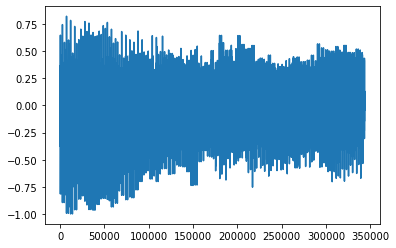

In [41]:
bit_array = bitsFromTiff('jaguar.tiff')
print('Length of bytes', len(bit_array)/8)

payload = fullTrans(bit_array, ofdm, ldpc_encode=False)
payload = payload / np.max(np.abs(payload.flatten()))
plt.plot((payload.flatten()))
print(np.shape(payload))
payload.flatten()[0]

In [4]:
data = bit_array
ldpc = LDPC(rate = ofdm.rate, z = ofdm.z)
ldpc_ified = ldpc.encode(data)

symb = bit2symbol(ldpc_ified, ofdm)

cut_symb = cut2Blocks(symb, ofdm)
# syb_padded = addpadding(cut_symb, ofdm)
all_symbs = goodSymbols(cut_symb,ofdm)
print(np.shape(all_symbs))
print(all_symbs[4][2048-ofdm.pilot_locs])
tds = ifft(all_symbs, 2048)
#print(addGuard(tds, ofdm))

(299, 2048)
[1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j 1.-1.j
 1.-1.j]


In [42]:
def CUSTARDtrial(payload,ofdm):
    chirp = double_chirp().flatten()
    exported_even, exported_odd = np.loadtxt('preamble_ofdm_symbols.csv',delimiter=',')
    two_snc = np.concatenate((exported_even, exported_odd)).flatten()
    four_snc = np.concatenate((two_snc, two_snc)).flatten()

    transmission = np.concatenate((chirp,four_snc))
    for i in range(len(payload)//ofdm.sfp):
        transmission = np.concatenate((transmission, payload[i*60:60*i+60].flatten(), two_snc))
    if len(payload)%ofdm.sfp != 0:
        transmission = np.concatenate((transmission, payload[-(len(payload)%ofdm.sfp):].flatten(), chirp))
    else:
        transmission = np.concatenate((transmission, chirp))
    
    return transmission

In [6]:
payload[-59:]
lens = -(len(payload)%ofdm.sfp)
len(payload[lens:])


59

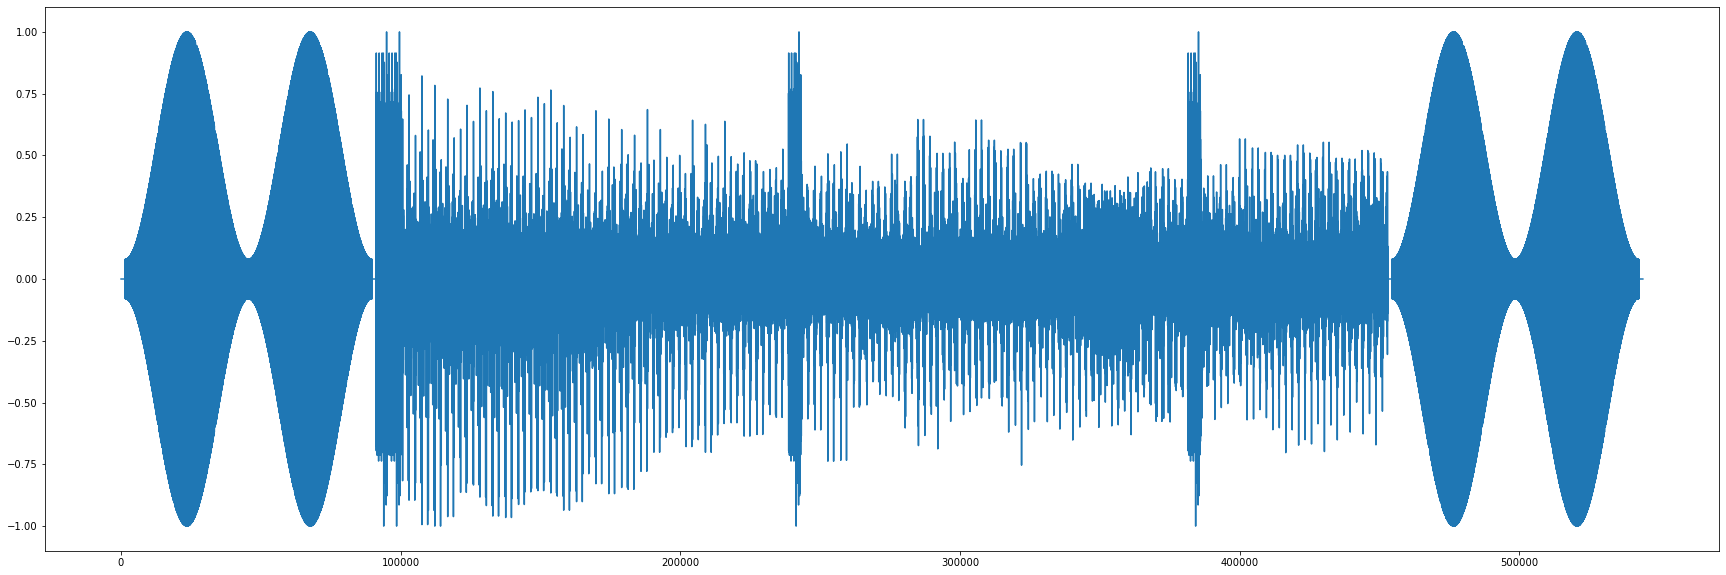

In [252]:
x = CUSTARDtrial(payload, ofdm)
plt.figure(figsize = (30, 10))
plt.plot(x)
audioMaker(x, 'jagtest2', fs)

plt.show()

In [8]:
chirp_time = 1
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=500, f1=15000, t1=chirp_time, method='linear')
note = note*np.hamming(len(note))

#delay_guess2 = np.abs(np.correlate(x, note, mode='full'))


In [9]:
# plt.plot(delay_guess)
# peaks = scipy.signal.find_peaks(delay_guess, 7000)[1]['peak_heights']


91200


452928

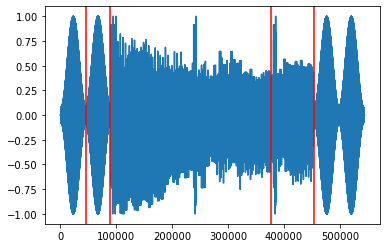

In [77]:

plt.plot(x)

plt.axvline(x = 45600 , color = 'r') 
plt.axvline(x = 89700 , color = 'r')
plt.axvline(x = 452928 , color = 'r')
plt.axvline(x = 124*2304+91200, color = 'r')
1500+44100,1500+44100*2
print((44100+1500)*2)
audioMaker(x, 'testframe3', fs)
len(x)-2*44100-3000

In [75]:
def channelEstimate(four_known_symbols, ofdm):

    even_one = four_known_symbols[:ofdm.N+ofdm.CP]
    odd_one = four_known_symbols[ofdm.N+ofdm.CP:2*(ofdm.N+ofdm.CP)]
    even_two = four_known_symbols[2*(ofdm.N+ofdm.CP):3*(ofdm.N+ofdm.CP)]
    odd_two = four_known_symbols[3*(ofdm.N+ofdm.CP):4*(ofdm.N+ofdm.CP)]
    odd_index = np.arange(0,741,2)
    even_index=np.arange(1,741,2)

    exported_coding = np.loadtxt('preamble_qpsk_symbols.csv', delimiter=',',dtype=complex)
    exported_coding *= 1.41421356474619

    hes_e1 = (fft(even_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o1 = (fft(odd_one[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_e2 = (fft(even_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    hes_o2 = (fft(odd_two[ofdm.CP:], 2048)).flatten()[49:790] / exported_coding.flatten()
    
    hest_one = np.zeros(741, dtype='complex')
    hest_one[even_index] = hes_e1[even_index]
    hest_one[odd_index] = hes_o1[odd_index]

    hest_two = np.zeros(741, dtype='complex')
    hest_two[even_index] = hes_e2[even_index]
    hest_two[odd_index] = hes_o2[odd_index]


    return hest_one, hest_two


def chanest_padd(hest,ofdm):
    full_size = np.ones(ofdm.N, dtype='complex')
    full_size[49:790] = hest
    return full_size


#end_of_chirps = scipy.signal.find_peaks(delay_guess, 7000)[0]
#a,b = channelEstimate(x[end_of_chirps[1]+1501:end_of_chirps[1]+1501+2304*4], ofdm)


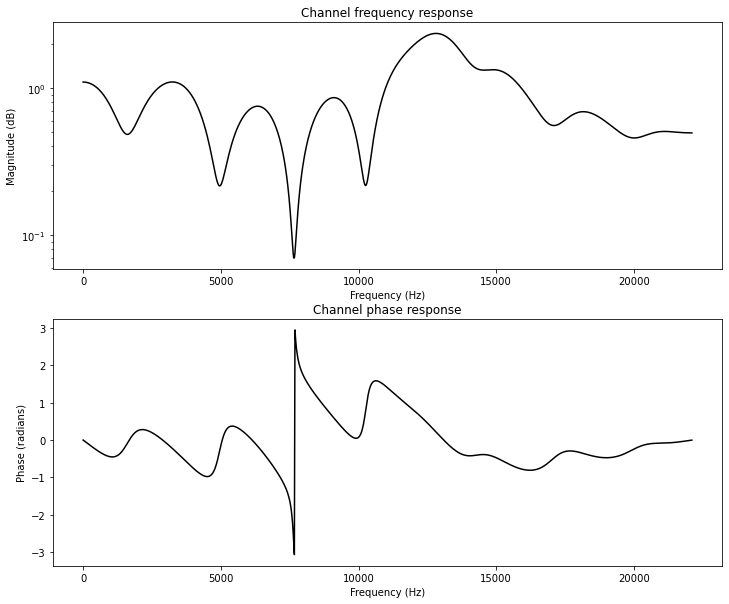

In [256]:
channel = np.array(['0.711725', '-0.0612732', '-0.147167', '0.41624', '0.0892594',
       '-0.299867', '0.0658993', '0.161483', '-0.167087', '-0.0731453',
       '0.148812', '-0.0179479', '-0.103307', '0.0674107', '0.267815',
       '0.120747', '-0.0788446', '0.00283828', '0.000199786',
       '-0.0176253', '0.0264058', '0.00439817', '-0.0282967',
       '0.00925993', '0.0192252', '-0.0160353', '-0.00768739',
       '0.0159742', '-0.00150132', '-0.0115726']).astype(np.float64)

def addChannel(signal, chan = channel):       
    return np.convolve(signal, chan)

x2 = addChannel(x,channel)
a,b = channelEstimate(x2[91200:91200+2304*4], ofdm)


import cmath
fig, axs = plt.subplots(2,1, figsize=(12,10))
freq = fft(channel, 2048)[:1024]

axs[0].plot(np.linspace(0,22105,len(freq)),abs(freq), color='black')
axs[0].set_yscale('log')
axs[0].set_title("Channel frequency response")
axs[0].set_xlabel("Frequency (Hz)")
axs[0].set_ylabel("Magnitude (dB)")

axs[1].plot(np.linspace(0,22105,len(freq)),[cmath.phase(x) for x in freq], color='black')
axs[1].set_title("Channel phase response")
axs[1].set_xlabel("Frequency (Hz)")
axs[1].set_ylabel("Phase (radians)")


'''plt.plot(abs(a))
plt.show()
plt.plot(abs(chanest_padd(b,ofdm)))
plt.show()
plt.plot(abs(fft(channel, 2048))[:1024])
plt.show()
plt.plot((channel))
plt.show()'''

fake_chann_decode = standard_deconstructor(x2[91200+2304*4:452928], ofdm, channel_H = chanest_padd(b,ofdm), ldpc_encoded=False)
bitsToSaveImage(fake_chann_decode[:214400], 'trialpayload2', 67, 100)

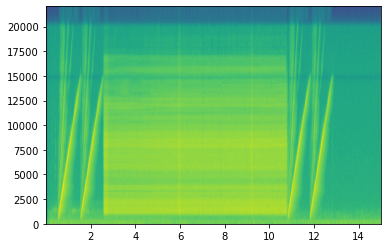

In [44]:
Fs, auds = read('testrecord4.wav')

powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(auds, Fs=fs)
plt.show()

In [45]:

chirp_time = 1
t = np.linspace(0, chirp_time, int(chirp_time * fs), False)
note = chirp(t, f0=500, f1=15000, t1=chirp_time, method='linear')
note = note*np.hamming(len(note))

delay_guess = np.abs(np.correlate(auds, note, mode='full'))

(array([ 68008,  68011,  68014, 112107, 112110, 520931, 520934, 565030,
       565033]), {'peak_heights': array([1.        , 0.97920842, 0.84421621, 0.81617897, 0.74433454,
       0.895459  , 0.78233875, 0.7777756 , 0.74578803])})


(44099, 44099)

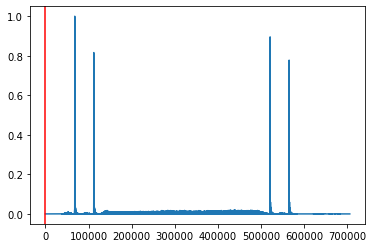

In [53]:
delay_guess = delay_guess/np.max(delay_guess)
plt.plot(delay_guess)
plt.axvline(x = 26 , color = 'r')


print(scipy.signal.find_peaks(delay_guess, 0.7))


end_first_chirp = 68008
end_second_chirp = 112107
end_third_chirp = 520931
end_fourth_chirp = 565030
delayed_start = end_second_chirp + 1500 + 1
delayed_end = end_third_chirp - 44100 - 1500 - 1
end_second_chirp-end_first_chirp, end_fourth_chirp-end_third_chirp

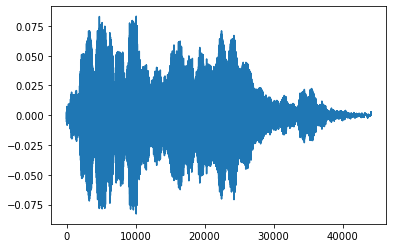

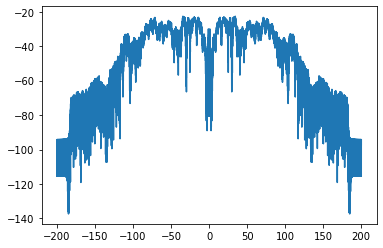

In [124]:
chirp_response = auds[delayed_start-1500-44100:delayed_start-1500]
plt.plot(chirp_response)
plt.show()
f = np.linspace(-200, 200, 4*len(chirp_response), endpoint=False)
plt.plot(f, 20*np.log10(abs(np.fft.fftshift(np.fft.fft(chirp_response, 4*len(chirp_response))/np.sqrt(len(chirp_response))))))
plt.show()

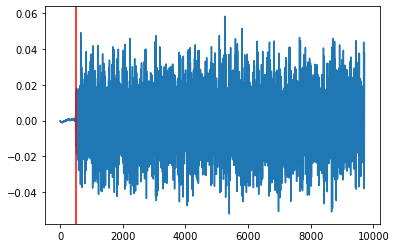

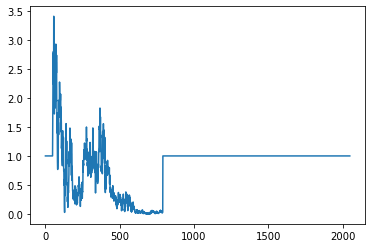

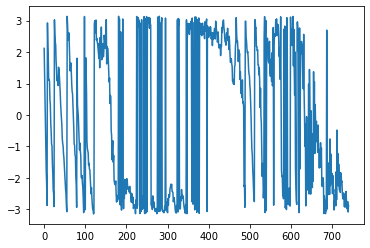

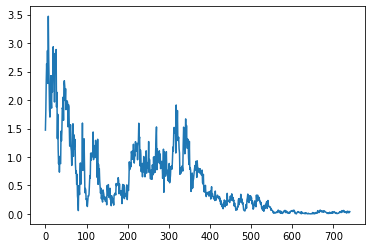

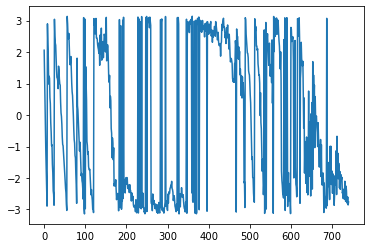

In [81]:
plt.plot(auds[delayed_start-500:delayed_start+2304*4])
plt.axvline(x = 500 , color = 'r')
plt.show()
ayy,bee = channelEstimate(auds[delayed_start:delayed_start+2304*4], ofdm)

plt.plot(abs(chanest_padd(ayy,ofdm)))
plt.show()
plt.plot(np.angle(ayy))
plt.show()
plt.plot(abs(bee))
plt.show()
plt.plot(np.angle(bee))
plt.show()

6 475336 475330
475336 475330


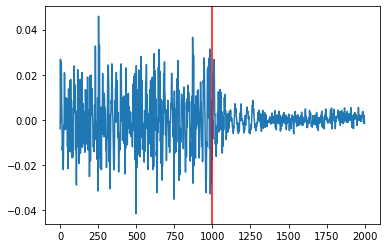

In [156]:
data_start  = delayed_start+2304*4

num_symbs_guess = round((delayed_end-data_start)/2304)
new_end = data_start + num_symbs_guess*2304
print(new_end-delayed_end, new_end, delayed_end)


plt.plot(auds[new_end-1000:new_end+1000])
plt.axvline(x = 1000 , color = 'r')
print(new_end, delayed_end)
decoded, symbols_rec = standard_deconstructor(auds[data_start:new_end], ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, ldpc_encoded = False)
bitsToSaveImage(decoded[:214400], 'trialpayload4', 67, 100)

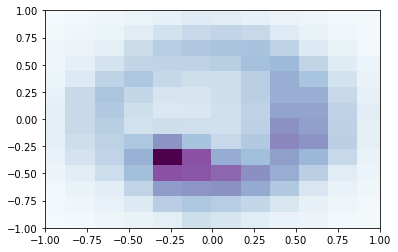

In [139]:
plt.hist2d(np.real(symbols_rec.flatten()), np.imag(symbols_rec.flatten()), bins=(300, 300),cmap=plt.cm.BuPu)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [84]:
initial = bitsFromTiff('jaguar.tiff')
initial, len(initial), decoded[:214400], len(decoded)

(array([1, 1, 1, ..., 1, 1, 1]), 214400)

0.31472222222222224


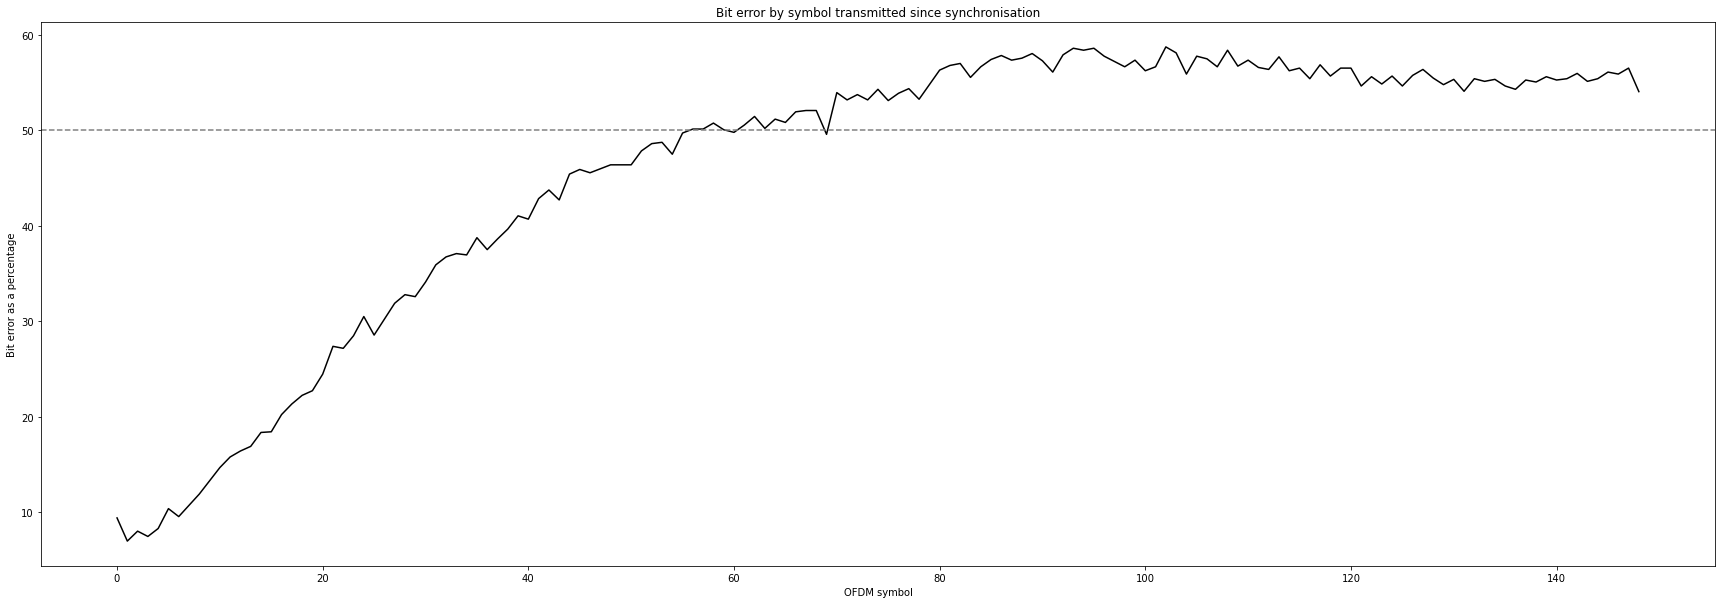

149

In [212]:
j = 0
r = 720*2 * 60
for i in range(r):
    if initial[i] != decoded[i]:
        j+=1
print(j/r)

def error_(data1,data_correct):
    errs = 0
    for i in range(len(data_correct)):
        if data_correct[i] != data1[i]:
            errs += 1
    return 100*errs/len(data_correct)

code_length = len(bit_array)
error_by_block = []
n=720*2
for i in range(0,code_length,n):
    error_by_block.append(error_(decoded[i:i+n],bit_array[i:i+n]))

    
plt.figure(figsize = (30, 10))

plt.plot(error_by_block,color='black')
plt.axhline(y = 50, color = 'grey', linestyle = '--')
plt.title("Bit error by symbol transmitted since synchronisation")

plt.xlabel("OFDM symbol")
plt.ylabel("Bit error as a percentage")
plt.show()
len(error_by_block)

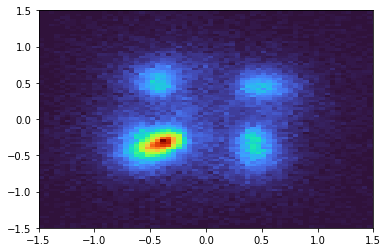

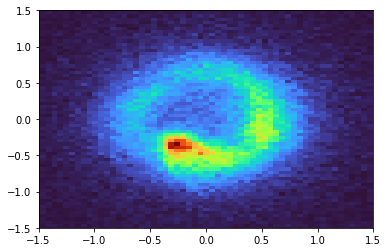

In [248]:
def resample(x, num, W):
    X = np.fft.fft(x)
    Nx = x.shape[0]
    XW = X*W
    N = int(np.minimum(num, Nx))
    Y = np.zeros(num, dtype=np.complex64)
    Y[0:(N+1)//2] = XW[0:(N+1)//2]
    Y[-(N-1)//2:] = XW[-(N-1)//2:]
    y = np.fft.ifft(Y) * (float(num) / float(Nx))
    return y

of=2
fo=0
win_len = delayed_end-data_start+of-fo
win = scipy.signal.get_window('boxcar', win_len)
resampled_aud3 = scipy.signal.resample(auds[data_start+fo:delayed_end+of], (new_end)-data_start, window=win)
resampled_aud2 = scipy.signal.resample(auds[data_start:new_end], (delayed_end)-data_start)
resampled_aud = resample(auds[data_start:new_end], 6, 2000)

wins, symbols_rec2 = standard_deconstructor(resampled_aud3, ofdm, channel_H = chanest_padd(ayy,ofdm), retSymbs = True, ldpc_encoded = False)

plt.hist2d(np.real(symbols_rec2.flatten()), np.imag(symbols_rec2.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()
plt.hist2d(np.real(symbols_rec.flatten()), np.imag(symbols_rec.flatten()), bins=(1000, 1000),cmap=plt.cm.turbo)
plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.show()

bitsToSaveImage(wins[:214400], 'trialpayload5', 67, 100)

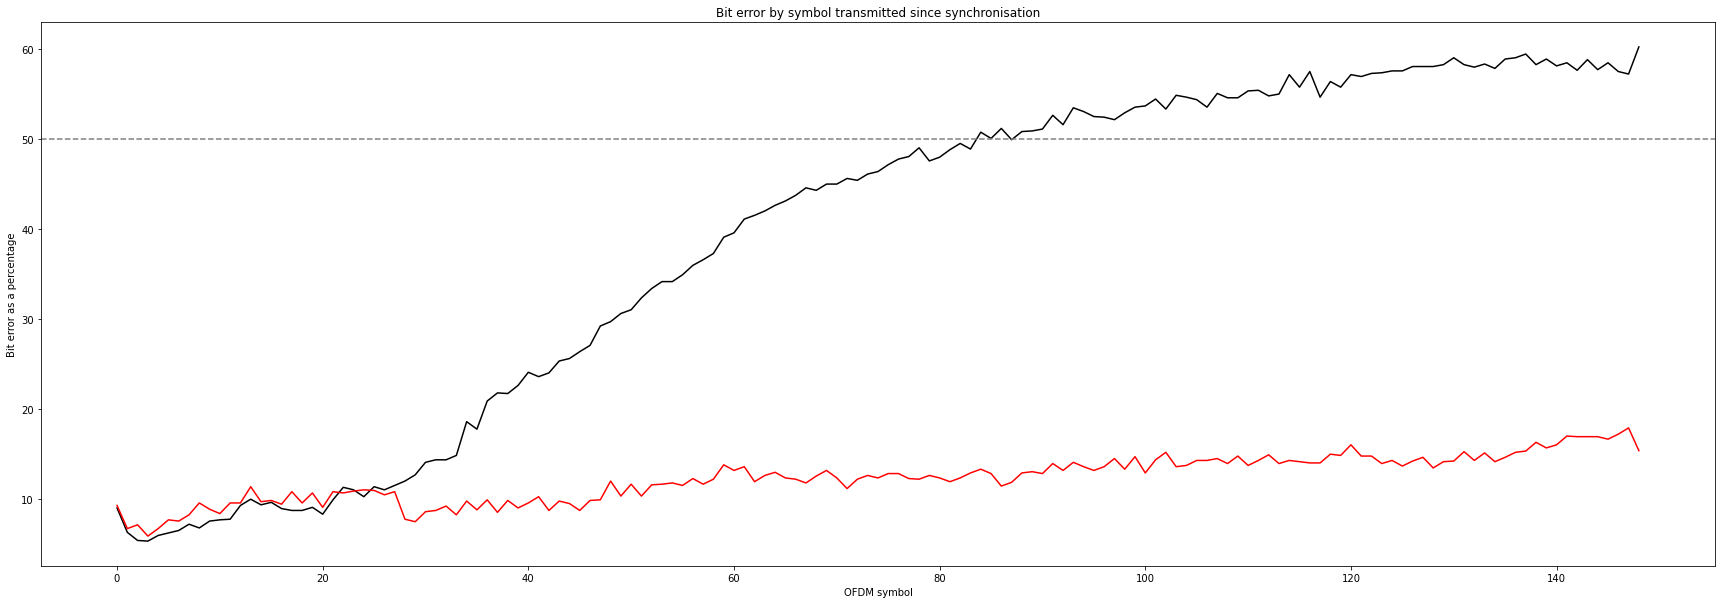

149

In [229]:
def errorss(decod):
    code_length = len(bit_array)
    error_by_block = []
    n=720*2
    for i in range(0,code_length,n):
        error_by_block.append(error_(decod[i:i+n],bit_array[i:i+n]))
    return error_by_block

    
plt.figure(figsize = (30, 10))

plt.plot(errorss(hamming),color='black')

plt.plot(errorss(wins),color='r')

plt.axhline(y = 50, color = 'grey', linestyle = '--')
plt.title("Bit error by symbol transmitted since synchronisation")

plt.xlabel("OFDM symbol")
plt.ylabel("Bit error as a percentage")
plt.show()
len(error_by_block)

In [271]:
x = np.arange(500)
l = len(x) #symbols.shape[0]
a1 = np.arange(60, l, 62)
a2 = np.arange(61, l, 62)
at = np.concatenate((a1,a2))
sc_indices = [i for i in range(l) if i not in at]

sc_indices[230:250]

at

array([ 60, 122, 184, 246, 308, 370, 432, 494,  61, 123, 185, 247, 309,
       371, 433, 495])

In [268]:
np.arange(200)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18